In [1]:
import os
import optuna
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

/data/ephemeral/home/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [55]:
# 파일 호출
data_path: str = "../data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [56]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")

100%|██████████| 107/107 [00:02<00:00, 37.79it/s]


In [60]:
df = df.dropna(axis=1, how="all")
df.fillna(method='ffill', inplace=True)

train_data = df[df["_type"] == "train"].drop(["target", "ID", "_type"], axis=1)
target = df[df["_type"] == "train"]["target"].astype(int)

test_data = df[df["_type"] == "test"].drop(["target", "ID", "_type"], axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(train_data, target, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# # 피처 중요도 시각화
# plt.figure(figsize=(12, 8))
# indices = np.argsort(importances)[::-1]
# plt.barh(range(X_train.shape[1]), importances[indices], align='center')
# plt.yticks(range(X_train.shape[1]), X_train.columns[indices])
# plt.xlabel('Feature Importance')
# plt.title('Feature Importance Distribution')
# plt.gca().invert_yaxis()
# plt.show()

# # 피처 중요도를 데이터프레임으로 변환 및 정렬
# feature_importance_df = pd.DataFrame({
#     'feature': X_train.columns,
#     'importance': importances
# }).sort_values(by='importance', ascending=False)

# # 피처 중요도 출력
# print(feature_importance_df)

# 피처 중요도 계산 및 정렬
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

threshold = feature_importance_df.iloc[69]['importance']

selector = SelectFromModel(rf_model, threshold=threshold, prefit=True)
X_train_selected = selector.transform(X_train)
X_valid_selected = selector.transform(X_valid)
X_test_selected = selector.transform(test_data)

rf_final_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_final_model.fit(X_train_selected, y_train)

y_valid_final_pred = rf_final_model.predict(X_valid_selected)
final_accuracy = accuracy_score(y_valid, y_valid_final_pred)

print("Final Validation Accuracy:", final_accuracy)
selected_features = X_train.columns[selector.get_support()]
print("Number of Selected Features:", len(selected_features))


/tmp/ipykernel_179598/4163843900.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/data/ephemeral/home/myenv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/data/ephemeral/home/myenv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/data/ephemeral/home/myenv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Final Validation Accuracy: 0.4474885844748858
Number of Selected Features: 70


In [62]:
# 전체 학습 데이터로 모델 재학습 및 예측 수행
x_train_full = train_data[selected_features]
y_train_full = target

rf_full_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_full_model.fit(x_train_full, y_train_full)

# 테스트 데이터 예측
y_test_pred = rf_full_model.predict(X_test_selected)

# 결과 저장
submission_df = pd.DataFrame({'ID': df[df["_type"] == "test"]["ID"], 'target': y_test_pred})
submission_df.to_csv("output.csv", index=False)

/data/ephemeral/home/myenv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [58]:
# LSTM 모델을 위한 데이터 준비
timesteps = 10

def create_sequences(data, targets, timesteps):
    sequences = []
    labels = []
    for i in range(len(data) - timesteps):
        seq = data[i:i+timesteps]
        label = targets[i+timesteps]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

X_train_seq, y_train_seq = create_sequences(X_train_selected, y_train.values, timesteps)
X_valid_seq, y_valid_seq = create_sequences(X_valid_selected, y_valid.values, timesteps)

train_dataset = TensorDataset(torch.tensor(X_train_seq, dtype=torch.float32),
                              torch.tensor(y_train_seq, dtype=torch.float32))
valid_dataset = TensorDataset(torch.tensor(X_valid_seq, dtype=torch.float32),
                              torch.tensor(y_valid_seq, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)

# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        h_lstm, _ = self.lstm(x)
        out = self.fc(h_lstm[:, -1, :])  # 마지막 타임스텝의 출력 사용
        return out

# 모델 초기화
input_size = X_train_selected.shape[1]
hidden_size = 50
model = LSTMModel(input_size=input_size, hidden_size=hidden_size)

# 손실 함수 및 옵티마이저 정의
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 훈련
epochs = 10
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        loss.backward()
        optimizer.step()

    # 검증 단계
    model.eval()
    valid_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            outputs = model(X_batch)
            valid_loss += criterion(outputs.squeeze(), y_batch).item()
            predictions = (torch.sigmoid(outputs.squeeze()) > 0.5).float()
            correct_predictions += (predictions == y_batch).sum().item()
            total_predictions += y_batch.size(0)

    accuracy = correct_predictions / total_predictions
    print(f"Epoch {epoch+1}/{epochs}, Validation Accuracy: {accuracy:.4f}")

Epoch 1/10, Validation Accuracy: 0.3875
Epoch 2/10, Validation Accuracy: 0.3875
Epoch 3/10, Validation Accuracy: 0.3875
Epoch 4/10, Validation Accuracy: 0.3875
Epoch 5/10, Validation Accuracy: 0.3875
Epoch 6/10, Validation Accuracy: 0.3875
Epoch 7/10, Validation Accuracy: 0.3875
Epoch 8/10, Validation Accuracy: 0.3875
Epoch 9/10, Validation Accuracy: 0.3875
Epoch 10/10, Validation Accuracy: 0.3875


제거할 다중공선성 특징 수: 149
{'hourly_market-data_open-interest_okx_btc_usdt_open_interest', 'hourly_market-data_liquidations_deribit_all_symbol_long_liquidations_usd', 'hourly_market-data_open-interest_binance_all_symbol_open_interest', 'hourly_market-data_liquidations_bybit_btc_usd_long_liquidations_usd', 'hourly_market-data_liquidations_huobi_global_all_symbol_long_liquidations', 'hourly_network-data_addresses-count_addresses_count_sender', 'hourly_market-data_liquidations_binance_btc_usdt_long_liquidations', 'hourly_network-data_fees_fees_block_mean_usd', 'hourly_market-data_liquidations_gate_io_btc_usdt_short_liquidations_usd', 'hourly_market-data_taker-buy-sell-stats_bitmex_taker_sell_volume', 'hourly_market-data_liquidations_bitmex_all_symbol_short_liquidations_usd', 'hourly_market-data_taker-buy-sell-stats_huobi_global_taker_buy_volume', 'hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio', 'hourly_market-data_liquidations_gate_io_all_symbol_long_liquidations_usd', 'ho

/data/ephemeral/home/myenv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


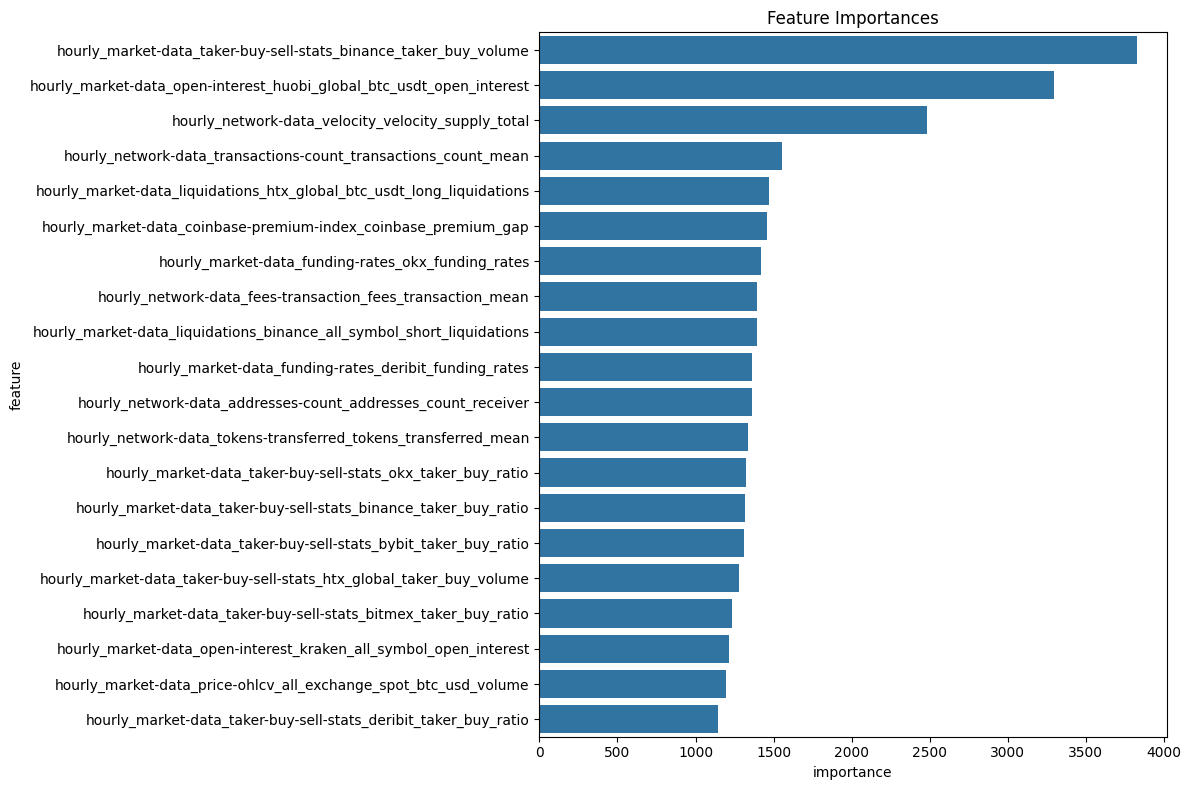

       hourly_market-data_taker-buy-sell-stats_binance_taker_buy_volume  \
0                                           4.151979e+07                  
1                                           3.177677e+07                  
2                                           1.907553e+07                  
3                                           2.349391e+07                  
4                                           2.614367e+07                  
...                                                  ...                  
11547                                       1.091095e+08                  
11548                                       1.481848e+08                  
11549                                       2.382681e+08                  
11550                                       1.068217e+08                  
11551                                       1.942222e+08                  

       hourly_market-data_open-interest_huobi_global_btc_usdt_open_interest  \
0                   

/data/ephemeral/home/myenv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


array([[0.87375782, 0.05310638, 0.05454029, 0.01859552],
       [0.87375782, 0.05310638, 0.05454029, 0.01859552],
       [0.87375782, 0.05310638, 0.05454029, 0.01859552],
       ...,
       [0.87002584, 0.05287955, 0.05430734, 0.02278728],
       [0.87016338, 0.05288791, 0.05431592, 0.02263279],
       [0.87030866, 0.05289674, 0.05432499, 0.02246962]])

In [28]:
numeric_df = df.select_dtypes(include=[float, int])
corr_matrix = numeric_df.corr().abs()

# 다중공선성 제거
threshold = 0.8
to_drop = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        feature1 = corr_matrix.columns[i]
        feature2 = corr_matrix.columns[j]
        if corr_matrix.loc[feature1, feature2] > threshold:
            to_drop.add(feature2)

print(f"제거할 다중공선성 특징 수: {len(to_drop)}")
print(to_drop)

# 다중공선성 제거 후 데이터프레임 생성
reduced_numeric_df = numeric_df.drop(columns=to_drop)

# 타겟과의 상관관계가 높은 상위 50개 특징 선택
target_corr = reduced_numeric_df.corr()['target'].abs().sort_values(ascending=False)
top_50_features = target_corr.head(51).index.tolist()  # 'target' 포함되므로 51개 선택 후 제거

if 'target' in top_50_features:
    top_50_features.remove('target')

print(f"타겟과의 상관관계가 높은 상위 50개 특징 수: {len(top_50_features)}")
print(top_50_features)

# 최종 특징 선택
X = reduced_numeric_df[top_50_features]
y = df['target']

# _type에 따라 train, test 분리
train_df_final = df.loc[df["_type"] == "train"].drop(columns=["_type"])
test_df_final = df.loc[df["_type"] == "test"].drop(columns=["_type"])

X_train_loc = X.loc[train_df_final.index]
y_train_loc = y.loc[train_df_final.index]
X_test_loc = X.loc[test_df_final.index]


# 학습 및 검증 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X_train_loc, y_train_loc, test_size=0.2, shuffle=False)


train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

params = {
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": 4,
    "num_leaves": 50,
    "learning_rate": 0.05,
    "n_estimators": 30,
    "random_state": 42,
    "verbose": 0,
}

model = lgb.train(params, train_data, valid_sets=[train_data, val_data])

importances = model.feature_importance(importance_type='gain')
feature_names = top_50_features
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

# 상위 20개 특징 시각화
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

final_features = feature_importance['feature'].head(20).tolist()

X_final = reduced_numeric_df[final_features]
y_final = reduced_numeric_df['target']

print(X_final)

scaler = StandardScaler()
X_final_scaled = scaler.fit_transform(X_final)

X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(X_final_scaled, y_final, test_size=0.2, shuffle=False)

train_data_final = lgb.Dataset(X_train_final, label=y_train_final)
val_data_final = lgb.Dataset(X_val_final, label=y_val_final, reference=train_data_final)

model_final = lgb.train(params, train_data_final, valid_sets=[train_data_final, val_data_final])

y_pred_final = model_final.predict(X_val_final)
y_pred_classes_final = np.argmax(y_pred_final, axis=1)


y_pred_final

# accuracy = accuracy_score(y_val_final, y_pred_classes_final)
# auroc = roc_auc_score(y_val_final, y_pred_final, multi_class="ovr")

# print(f"acc: {accuracy}, auroc: {auroc}")
